# <span style='color:SteelBlue'>P8 - Déployer un modèle dans le cloud</span>

<img style="padding-left:130px;" src = 'https://community.cloud.databricks.com/files/tables/resources/images/entreprise_fruits.png' />

# <span style='background:SteelBlue; color:white'>P8_01_01 - CLOUD - LOCAL Databricks Community Edition</span>

Ce notebook traite de du chargement du jeu de données des images, du pré-processing, de la réduction de dimension et d'une mini classification pour des nouvelles images.

## <span style='background:Thistle'>1. Introduction</span>

*****
**Mission**
*****
**Développer dans un environnement Big Data une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension** pour une startup Fruits! de l'AgriTech pour mettre à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.

*****
**Contraintes**
*****
- Le volume de données va augmenter très rapidement après la livraison de ce projet.
- Développer des scripts en Pyspark.
- Utiliser le cloud AWS ou autre (Microsoft Azure sera utilisé pour ce projet) pour profiter d’une architecture Big Data. 

*****
**Sources**
*****
- [Jeu de données](https://www.kaggle.com/moltean/fruits) : constitué des images de fruits et des labels associés, qui pourra servir de point de départ pour construire une partie de la chaîne de traitement des données.

**Information sur le jeu de données :**
***

- Nombre **total d'images** : **90483**.
- Jeu de données **train set** : **67692** images (1 fruit ou 1 légumes par image).
- Jeu de données **test set** : **22688**  images (1 fruit ou 1 légumes par image).
- Nombre de **classes** : 131 (fruits ou légumes).
- **Taille** des images : 100x100 pixels.
- **Format du nom de fichier** : 
  - **imageindex100.jpg** (par exemple 32100.jpg),
  - ou **rimageindex100.jpg** (par exemple r32100.jpg),
  - ou **r2imageindex100.jpg**,
  - ou **r3imageindex100.jpg**. 
     - ou "r" signifie que le fruit a subi une rotation,
     - "r2" signifie que le fruit a été tourné autour du 3ème axe,
     - "100" vient de la taille de l'image (100x100 pixels).
- Exemples de classe : Apples (different varieties: Crimson Snow, Golden, Golden-Red, Granny Smith, Pink Lady, Red, Red Delicious), Apricot, Avocado, Avocado ripe, Banana (Yellow, Red, Lady Finger), Beetroot Red, Blueberry, Cactus fruit, Cantaloupe (2 varieties), Carambula, Cauliflower, Cherry (different varieties, Rainier), Cherry Wax (Yellow, Red, Black), Chestnut, Clementine, Cocos, Corn (with husk), Cucumber (ripened), Dates, Eggplant, Fig, Ginger Root, Granadilla, Grape (Blue, Pink, White (different varieties)), Grapefruit (Pink, White), Guava, Hazelnut, Huckleberry, Kiwi, Kaki, Kohlrabi, Kumsquats, Lemon (normal, Meyer), Lime, Lychee, Mandarine, Mango (Green, Red), Mangostan, Maracuja, Melon Piel de Sapo, Mulberry, Nectarine (Regular, Flat), Nut (Forest, Pecan), Onion (Red, White), Orange, Papaya, Passion fruit, Peach (different varieties), Pepino, Pear (different varieties, Abate, Forelle, Kaiser, Monster, Red, Stone, Williams), Pepper (Red, Green, Orange, Yellow), Physalis (normal, with Husk), Pineapple (normal, Mini), Pitahaya Red, Plum (different varieties), Pomegranate, Pomelo Sweetie, Potato (Red, Sweet, White), Quince, Rambutan, Raspberry, Redcurrant, Salak, Strawberry (normal, Wedge), Tamarillo, Tangelo, Tomato (different varieties, Maroon, Cherry Red, Yellow, not ripened, Heart), Walnut, Watermelon.

In [0]:
# Chargement des librairies
import datetime
import io
import sys
import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Pyspark
import pyspark
from pyspark.sql.functions import element_at, split, col, pandas_udf, PandasUDFType, udf
from pyspark.sql.types import StringType

# Tensorflow Keras
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Gestion des images
import PIL
from PIL import Image

# Taches ML
from pyspark.ml.image import ImageSchema

# Réduction de dimension - PCA
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

# Modélisation
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

%matplotlib inline

# Versions
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('tensorflow    : ' + tf.__version__)
print('pyspark       : ' + pyspark.__version__)
print('PIL           : ' + PIL.__version__)
print('Numpy         : ' + np.__version__)
print('Pandas        : ' + pd.__version__)
print('Matplotlib    : ' + matplotlib.__version__)
now = datetime.now().isoformat()
print('Lancé le      : ' + now)

Version des librairies utilisées :
Python : 3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]
tensorflow : 2.5.0
pyspark : 3.1.2
PIL : 8.0.1
Numpy : 1.19.2
Pandas : 1.1.5
Matplotlib : 3.2.2
Sklearn : 0.23.2
Lancé le : 2021-09-07T14:55:13.963714

## <span style='background:Thistle'>2. Préparation des données du train set</span>

### <span style='background:PowderBlue'>2.1. Jeu de données train set - au format "image"</span>

#### <span style='background:Moccasin'>2.1.1. Chargement du jeu de données train set - au format "image"</span>

Chargement de quelques répertoires d'images du train set pour tester les scripts pyspark avant la mise en production et gagner en ressources et en temps de réponses.

- [Source_image_apache_spark](https://docs.microsoft.com/fr-fr/archive/blogs/machinelearning/image-data-support-in-apache-spark)
- [Source_2](https://databricks.com/fr/blog/2018/12/10/introducing-built-in-image-data-source-in-apache-spark-2-4.html)

In [0]:
# Chemin de stockage des images du jeu de données
path_train_set = 'dbfs:/FileStore/tables/resources/data/train-set/*/*'

In [0]:
# Chargement au format 'image' des images du train set
# avec option inferSchema pour déduire automatiquement les types de colonnes
# en fonction des données
df_img_train = spark.read.format('image').load(path_train_set, inferschema=True) 

In [0]:
# Schéma?
df_img_train.printSchema()

root
-- image: struct (nullable = true)
 |-- origin: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- width: integer (nullable = true)
 |-- nChannels: integer (nullable = true)
 |-- mode: integer (nullable = true)
 |-- data: binary (nullable = true)

In [0]:
# Nombre d'images?
print(df_img_train.count())

800

In [0]:
# Afficher les images
display(df_img_train.head(5))

image
"List(dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/45_100.jpg, 100, 100, 3, 16, ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////+//78//77//3/+f3/+vv/+vv//fr///v//Pn//fr///o= (truncated))"
"List(dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/44_100.jpg, 100, 100, 3, 16, ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////+///7//7/6Ofx+/v/+vr/+/v/+fj/+vv/9/v/+P3/+/s= (truncated))"
"List(dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/52_100.jpg, 100, 100, 3, 16, /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////f//+/78+//+//7///////3+///++v7/+v//+/v//f///f4= (truncated))"
"List(dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/42_100.jpg, 100, 100, 3, 16, ///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////8///32NXQw7/LycPaz8bb//j///f///r/+/r/+vv/+fk= (truncated))"
"List(dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/51_100.jpg, 100, 100, 3, 16, //////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////7//P3///7////8///7/f/8/f////3///7/+f7/9//9//8= (truncated))"


In [0]:
# Affiche la première image du dataframe
# Transforme de format bianire en Array avec RGB mode
ImageArray_first = ImageSchema.toNDArray(df_img_train.first()['image'])[:, :, ::-1]
Image.fromarray(ImageArray_first)

Out[23]: <PIL.Image.Image image mode=RGB size=100x100 at 0x7F5FBA7168B0>

In [0]:
#affichage d'une image
import numpy as np
a = df_img_train.first()
b = np.array(a.asDict()['image']['data']).reshape(100,100,3)[:,:,::-1]
print(b.shape)
Image.fromarray(b, 'RGB')

(100, 100, 3)
Out[24]: <PIL.Image.Image image mode=RGB size=100x100 at 0x7F5FBA5056D0>

In [0]:
# Visualisation des images - 20 premières (par défaut)
df_img_train.show()

+--------------------+
 image|
+--------------------+
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
{dbfs:/FileStore/...|
+--------------------+
only showing top 20 rows

In [0]:
# Visualisation nom de la première image
df_img_train.select('image.origin').show(1, False)

+--------------------------------------------------------------------+
origin |
+--------------------------------------------------------------------+
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/45_100.jpg|
+--------------------------------------------------------------------+
only showing top 1 row

In [0]:
# Visualisation du répertoire et dimension es 20 premières images
df_img_train.select("image.origin", "image.width", "image.height").show(truncate=False)

+--------------------------------------------------------------------+-----+------+
origin |width|height|
+--------------------------------------------------------------------+-----+------+
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/45_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/44_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/52_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/42_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/51_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/43_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/46_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/54_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/50_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/47_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/48_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/49_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/39_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/53_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/40_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/36_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/41_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/37_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/38_100.jpg|100 |100 |
dbfs:/FileStore/tables/resources/data/train-set/Onion-Red/35_100.jpg|100 |100 |
+--------------------------------------------------------------------+-----+------+
only showing top 20 rows

#### <span style='background:Moccasin'>2.1.2. Labellisation - extraction de la classe de l'image</span>

- La classe de l'image traitée est définie dans le nom du répertoire de l'image.
- Exemple : répertoire : dbfs:/FileStore/tables/resources/data/train-set/**Onion-Red**/43_100.jpg ==> **classe='Onion-Red'**.

In [0]:
# Ajout dans la colonne Classe pour chaque image traitée de l'avant dernier
# élément du nom du répertoire de stockage de l'image==>df_img_train["image.origin"]
df_img_train = df_img_train.withColumn("Classe", element_at(split(df_img_train["image.origin"], "/"), -2))

In [0]:
# Schéma ?
df_img_train.printSchema()

root
-- image: struct (nullable = true)
 |-- origin: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- width: integer (nullable = true)
 |-- nChannels: integer (nullable = true)
 |-- mode: integer (nullable = true)
 |-- data: binary (nullable = true)
-- Classe: string (nullable = true)

In [0]:
# Visualisation des 20 premières images avec la classe
df_img_train.show()

+--------------------+---------+
 image| Classe|
+--------------------+---------+
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
{dbfs:/FileStore/...|Onion-Red|
+--------------------+---------+
only showing top 20 rows

### <span style='background:PowderBlue'>2.2. Jeu de données train set - au format "binaryFile"</span>

#### <span style='background:Moccasin'>2.2.1. Chargement du jeu de données train set - au format "binaryFile"</span>

**Recommandation databricks** : 

Databricks recommande d’utiliser la source de données de fichier binaire pour charger des données d’image dans le tableau Spark en tant qu’octets bruts.

[Source](https://docs.microsoft.com/fr-fr/azure/databricks/data/data-sources/image)

***Note***:
***
Ce format sera ainsi utilisé pour la mise en production via Microsoft Azure.

In [0]:
# Chemin de stockage des images du jeu de données
path_train_set = 'dbfs:/FileStore/tables/resources/data/train-set/*/*'

In [0]:
# Chargement des images du train set au format "binaryFile"
df_binary_train = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(path_train_set)

In [0]:
# Schéma ?
df_binary_train.printSchema()

root
-- path: string (nullable = true)
-- modificationTime: timestamp (nullable = true)
-- length: long (nullable = true)
-- content: binary (nullable = true)

In [0]:
# Nombre d'images?
df_binary_train.count()

Out[13]: 800

In [0]:
# Visualisation des 20 premières images
df_binary_train.show()

+--------------------+-------------------+------+--------------------+
 path| modificationTime|length| content|
+--------------------+-------------------+------+--------------------+
dbfs:/FileStore/t...|2021-09-06 10:10:42| 5574|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:41| 5573|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:48| 5568|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:41| 5564|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:47| 5556|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:41| 5548|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:42| 5543|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:49| 5542|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:47| 5536|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:43| 5535|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:43| 5533|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:44| 5514|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:39| 5510|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:48| 5510|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:40| 5505|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:38| 5504|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:40| 5494|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:39| 5475|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:39| 5467|[FF D8 FF E0 00 1...|
dbfs:/FileStore/t...|2021-09-06 10:10:38| 5423|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 20 rows

#### <span style='background:Moccasin'>2.2.2. Labellisation - extraction de la classe de l'image</span>

- La classe de l'image traitée est définie dans le nom du répertoire de l'image.
- Exemple : répertoire : dbfs:/FileStore/tables/resources/data/train-set/**Onion-Red**/43_100.jpg ==> **classe='Onion-Red'**.

In [0]:
# Ajout dans la colonne Classe pour chaque image traitée de l'avant dernier
# élément du nom du répertoire de stockage de l'image==>df_binary_train["path"]
df_binary_train = df_binary_train.withColumn("Classe", element_at(split(df_binary_train["path"], "/"), -2))

In [0]:
# Schéma ?
df_binary_train.printSchema()

root
-- path: string (nullable = true)
-- modificationTime: timestamp (nullable = true)
-- length: long (nullable = true)
-- content: binary (nullable = true)
-- Classe: string (nullable = true)

In [0]:
# Visualisation des 20 premières images avec la classe
df_binary_train.show()

+--------------------+-------------------+------+--------------------+---------+
 path| modificationTime|length| content| Classe|
+--------------------+-------------------+------+--------------------+---------+
dbfs:/FileStore/t...|2021-09-06 10:10:42| 5574|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:41| 5573|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:48| 5568|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:41| 5564|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:47| 5556|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:41| 5548|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:42| 5543|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:49| 5542|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:47| 5536|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:43| 5535|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:43| 5533|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:44| 5514|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:39| 5510|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:48| 5510|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:40| 5505|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:38| 5504|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:40| 5494|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:39| 5475|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:39| 5467|[FF D8 FF E0 00 1...|Onion-Red|
dbfs:/FileStore/t...|2021-09-06 10:10:38| 5423|[FF D8 FF E0 00 1...|Onion-Red|
+--------------------+-------------------+------+--------------------+---------+
only showing top 20 rows

## <span style='background:Thistle'>3. Extraction des features importantes pour chaque image</span>

- Comme vu lors du projet 6, l'extraction des features par transfert learning donne des résultats plus performants que les méthodes anciennes (ORB, SIFT). 
- Nous allons donc extraire les features les plus importantes pour la classification de nos images en utilisant un modèle **[InceptionV3](https://www.researchgate.net/figure/Schematic-diagram-of-the-Inception-v3-model-based-on-convolutional-neural-networks_fig3_337200783)** de deep learning pré-entrainé sur de la classification d'images.
- Comme le but de ce projet n'est pas d'effectuer la classification; La dernière couche (softmax), qui effectue la classification, est supprimée à l'aide du paramètre (include_top=False). Cela nous permettra de choisir un modèle de classification adapté à nos classes.

### <span style='background:PowderBlue'>3.1. Préparation du dataframe de travail</span>

Le dataframe de travail sera composé des colonnes utiles à partir du dataframe des images binaires :
- le répertoire de stockage de l'image (colonne path),
- le label (colonne Classe) de chaque image,
- les features les plus importantes ajoutées après exécution du modèle (étape 3.3.).

In [0]:
df_images = df_binary_train.select("path", "Classe")
df_images.show()

+--------------------+---------+
 path| Classe|
+--------------------+---------+
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
dbfs:/FileStore/t...|Onion-Red|
+--------------------+---------+
only showing top 20 rows

### <span style='background:PowderBlue'>3.2. Préparation du modèle InceptionV3</span>

Utilisation de la technique de transfert learning pour extraire les features de chaque image avec le modèle **[InceptionV3](https://keras.io/api/applications/inceptionv3/)** de la librairie Keras de tensorflow avec l'aide des recommandations de databricks sur l'utilisation du transfert learning.

***Note : Recommandation de databricks***
***
- Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
`spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")`
- Pour les modèles de taille modérée (< 1 Go, c'est le cas de notre projet), une bonne pratique consiste à télécharger le modèle vers le pilote Spark, puis à diffuser les poids aux travailleurs. Ce carnet de notes utilise cette approche.
`bc_model_weights = sc.broadcast(model.get_weights())`
`model.set_weights(bc_model_weights.value)`

[Source](https://docs.databricks.com/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html)

In [0]:
# Instanciation du modèle
model = InceptionV3(
        include_top=False,  # Couche softmax de classification supprimée
        weights='imagenet',  # Poids pré-entraînés sur Imagenet
        input_shape=(100,100,3), # Image de taille 100x100 en couleur (channel=3)
        pooling='max' # Utilisation du max de pooling
)

Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
 8192/87910968 [..............................] - ETA: 3s 237568/87910968 [..............................] - ETA: 18s 3784704/87910968 [>.............................] - ETA: 2s 12107776/87910968 [===>..........................] - ETA: 0s20054016/87910968 [=====>........................] - ETA: 0s27598848/87910968 [========>.....................] - ETA: 0s35799040/87910968 [===========>..................] - ETA: 0s44482560/87910968 [==============>...............] - ETA: 0s52862976/87910968 [=================>............] - ETA: 0s61366272/87910968 [===================>..........] - ETA: 0s69468160/87910968 [======================>.......] - ETA: 0s77406208/87910968 [=========================>....] - ETA: 0s85671936/87910968 [============================>.] - ETA: 0s87916544/87910968 [==============================] - 1s 0us/step

In [0]:
# Description des caractéristiques du modèle
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type) Output Shape Param # Connected to 
==================================================================================================
input_1 (InputLayer) [(None, 100, 100, 3) 0 
__________________________________________________________________________________________________
conv2d (Conv2D) (None, 49, 49, 32) 864 input_1[0][0] 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32) 96 conv2d[0][0] 
__________________________________________________________________________________________________
activation (Activation) (None, 49, 49, 32) 0 batch_normalization[0][0] 
__________________________________________________________________________________________________
conv2d_1 (Conv2D) (None, 47, 47, 32) 9216 activation[0][0] 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 47, 47, 32) 96 conv2d_1[0][0] 
__________________________________________________________________________________________________
activation_1 (Activation) (None, 47, 47, 32) 0 batch_normalization_1[0][0] 
__________________________________________________________________________________________________
conv2d_2 (Conv2D) (None, 47, 47, 64) 18432 activation_1[0][0] 
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 47, 47, 64) 192 conv2d_2[0][0] 
__________________________________________________________________________________________________
activation_2 (Activation) (None, 47, 47, 64) 0 batch_normalization_2[0][0] 
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64) 0 activation_2[0][0] 
__________________________________________________________________________________________________
conv2d_3 (Conv2D) (None, 23, 23, 80) 5120 max_pooling2d[0][0] 
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 23, 23, 80) 240 conv2d_3[0][0] 
__________________________________________________________________________________________________
activation_3 (Activation) (None, 23, 23, 80) 0 batch_normalization_3[0][0] 
__________________________________________________________________________________________________
conv2d_4 (Conv2D) (None, 21, 21, 192) 138240 activation_3[0][0] 
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 21, 21, 192) 576 conv2d_4[0][0] 
__________________________________________________________________________________________________
activation_4 (Activation) (None, 21, 21, 192) 0 batch_normalization_4[0][0] 
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D) (None, 10, 10, 192) 0 activation_4[0][0] 
__________________________________________________________________________________________________
conv2d_8 (Conv2D) (None, 10, 10, 64) 12288 max_pooling2d_1[0][0] 
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 10, 10, 64) 192 conv2d_8[0][0] 
__________________________________________________________________________________________________
activation_8 (Activation) (None, 10, 10, 64) 0 batch_normalization_8[0][0] 
__________________________________________________________________________________________________
conv2d_6 (Conv2D) (None, 10, 10, 48) 9216 max_pooling2d_1[0][0] 
__________________________________________________________________________________________________
conv2d_9 (Conv2D) (None, 10, 10, 96) 55296 activation_

Le vecteur des features est de dimension de chaque image à la dimensions (1, 1, 2048)

### <span style='background:PowderBlue'>3.3. Extraction des features pour chaque image</span>

[Source_databricks](https://docs.databricks.com/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html)

#### <span style='background:Moccasin'>3.3.1. Fonctions utiles à l'extraction des features</span>

**Préparation du modèle**
***

In [0]:
# Instanciation du modèle
model = InceptionV3(
        include_top=False,  # Couche softmax de classification supprimée
        weights='imagenet',  # Poids pré-entraînés sur Imagenet
        input_shape=(100,100,3), # Image de taille 100x100 en couleur (channel=3)
        pooling='max' # Utilisation du max de pooling
)

In [0]:
# Permettre aux workers Spark d'accéder aux poids utilisés par le modèle
bc_model_weights = spark.sparkContext.broadcast(model.get_weights())

In [0]:
def model_fn():
  """
  Renvoie un modèle Inception3 avec la couche supérieure supprimée et les poids pré-entraînés sur imagenet diffusés.
  """
  model = InceptionV3(
        include_top=False,  # Couche softmax de classification supprimée
        weights='imagenet',  # Poids pré-entraînés sur Imagenet
#         input_shape=(100,100,3), # Image de taille 100x100 en couleur (channel=3)
        pooling='max' # Utilisation du max de pooling
  )
  model.set_weights(bc_model_weights.value)
  
  return model

**Fonction de redimensionnement de l'image**
***
Les images à transmettre en entrée de InceptionV3 doivent entre de dimension (299,299, 3)

In [0]:
# Redimensionnement des images en 299x299
def preprocess(content):
    """
    Prétraite les octets de l'image brute pour la prédiction.
    param : content : objet image, obligatoire
    return : image redimensionnée en Array
    """
    # lecture + redimension (299x299) pour Xception
    img = PIL.Image.open(io.BytesIO(content)).resize([299, 299])
    # transforme l'image en Array     
    arr = img_to_array(img)
    return preprocess_input(arr)

**Extraction des features par le modèle dans un vecteur**
***

In [0]:
# Extraction des features par le modèle dans un vecteur
def featurize_series(model, content_series):
  """
  Featurise une pd.Series d'images brutes en utilisant le modèle d'entrée.
  param : 
    model : modèle à utiliser pour l'extraction, obligatoire.
    content_series : image redimensionnée (299, 299, 3) en Array
  :return: les features importantes de l'image en pd.Series.
  """
  input = np.stack(content_series.map(preprocess))
  # Prédiction du modèle
  preds = model.predict(input)
  # Pour certaines couches, les caractéristiques de sortie seront des tenseurs multidimensionnels.
  # Nous aplatissons les tenseurs de caractéristiques en vecteurs pour faciliter le stockage dans
  # les DataFrames de Spark.
  output = [p.flatten() for p in preds]
  
  return pd.Series(output)

In [0]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
  '''
  Cette méthode est un Scalar Iterator pandas UDF enveloppant notre fonction de featurisation.
  Le décorateur spécifie que cette méthode renvoie une colonne Spark DataFrame de type ArrayType(FloatType).
  
  :param content_series_iter : Cet argument est un itérateur sur des lots de données, où chaque lot est une série pandas de données d'image.
  '''
  # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
  # for multiple data batches.  This amortizes the overhead of loading big models.
  model = model_fn()
  for content_series in content_series_iter:
    yield featurize_series(model, content_series)

/databricks/spark/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
 warnings.warn(

#### <span style='background:Moccasin'>3.3.2. Extraction des features pour chaque image du dataframe</span>

In [0]:
# Les UDF de Pandas sur de grands enregistrements (par exemple, de très grandes images) peuvent rencontrer des erreurs de type Out Of Memory (OOM).
# Si vous rencontrez de telles erreurs dans la cellule ci-dessous, essayez de réduire la taille du lot Arrow via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [0]:
# Nous pouvons maintenant exécuter la featurisation sur l'ensemble de notre DataFrame Spark.
# REMARQUE : Cela peut prendre beaucoup de temps (environ 10 minutes) car il applique un grand modèle à l'ensemble des données.
features_df = df_binary_train.repartition(16).select(col("path"), col('Classe'), featurize_udf("content").alias("features"))

In [0]:
# 800 images?
features_df.count()

Out[30]: 800

In [0]:
# Exemple des features?
features_df.show()

+--------------------+---------+--------------------+
 path| Classe| features|
+--------------------+---------+--------------------+
dbfs:/FileStore/t...|Onion-Red|[1.0997448, 0.956...|
dbfs:/FileStore/t...|Onion-Red|[1.178364, 0.8063...|
dbfs:/FileStore/t...|Onion-Red|[1.2310934, 1.017...|
dbfs:/FileStore/t...|Onion-Red|[1.2069545, 1.638...|
dbfs:/FileStore/t...|Onion-Red|[1.9531668, 0.838...|
dbfs:/FileStore/t...|Onion-Red|[1.4262064, 0.447...|
dbfs:/FileStore/t...|Onion-Red|[0.87775123, 1.55...|
dbfs:/FileStore/t...|Onion-Red|[2.5070534, 0.761...|
dbfs:/FileStore/t...|Onion-Red|[2.1061568, 1.240...|
dbfs:/FileStore/t...| Apricot|[1.4493053, 0.551...|
dbfs:/FileStore/t...| Avocado|[0.62642586, 1.15...|
dbfs:/FileStore/t...| Avocado|[0.88972914, 1.05...|
dbfs:/FileStore/t...| Apricot|[1.0919037, 0.991...|
dbfs:/FileStore/t...| Apricot|[1.3992665, 0.750...|
dbfs:/FileStore/t...| Apricot|[0.964555, 0.7709...|
dbfs:/FileStore/t...| Avocado|[1.215371, 1.6071...|
dbfs:/FileStore/t...| Cherry 1|[0.9060954, 1.103...|
dbfs:/FileStore/t...| Avocado|[0.70657074, 1.18...|
dbfs:/FileStore/t...| Cherry 1|[1.4112222, 1.771...|
dbfs:/FileStore/t...| Avocado|[0.9958029, 1.501...|
+--------------------+---------+--------------------+
only showing top 20 rows

### <span style='background:PowderBlue'>3.4. Réduction de dimension - Principal Component Analysis</span>

#### <span style='background:Moccasin'>3.4.1. Recherche meilleur nombre de composante</span>

**Préparation des données**

In [0]:
def preprocess_pca(dataframe):
  '''
     Préparation des données :
     - transformation en vecteur dense
     - standardisation
     param : dataframe : dataframe d'images
     return : dataframe avec features vecteur dense standardisé
  '''
  
  # Préparation des données - conversion des données images en vecteur dense
  transform_vecteur_dense = udf(lambda r: Vectors.dense(r), VectorUDT())
  dataframe = dataframe.withColumn('features_vectors', transform_vecteur_dense('features'))
  
  # Standardisation obligatoire pour PCA
  scaler_std = StandardScaler(inputCol="features_vectors", outputCol="features_scaled", withStd=True, withMean=True)
  model_std = scaler_std.fit(dataframe)
  # Mise à l'échelle
  dataframe = model_std.transform(dataframe)
  
  return dataframe

**Recherche du nombre de composante expliquant 95% de la variance**

In [0]:
def recherche_nb_composante(dataframe, nb_comp=400):
    '''
       Recherche d nombre de composante expliquant 95% de la variance
       param : dataframe : dataframe d'images
       return : k nombre de composante expliquant 95% de la variance totale
    '''
    
    pca = PCA(k = nb_comp,
              inputCol="features_scaled", 
              outputCol="features_pca")
 
    model_pca = pca.fit(dataframe)
    variance = model_pca.explainedVariance
 
    # visuel
    plt.plot(np.arange(len(variance)) + 1, variance.cumsum(), c="red", marker='o')
    plt.xlabel("Nb composantes")
    plt.ylabel("% variance")
    plt.show(block=False)
 
    def nb_comp ():
      for i in range(500):
          a = variance.cumsum()[i]
          if a >= 0.95:
              print("{} composantes principales expliquent au moins 95% de la variance totale".format(i))
              break
      return i
 
    k=nb_comp()
  
    return k


In [0]:
# Pré-processing (vecteur dense, standardisation)
df_pca = preprocess_pca(features_df)

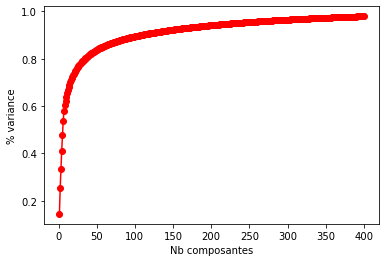

228 composantes principales expliquent au moins 95% de la variance totale

In [0]:
# Nombre de composante expliquant 95% de la variance
n_components = recherche_nb_composante(df_pca)

#### <span style='background:Moccasin'>3.4.2. Réduction de dimension PCA</span>

In [0]:
# Entrainement de l'algorithme
pca = PCA(k=n_components, inputCol='features_scaled', outputCol='vectors_pca')
model_pca = pca.fit(df_pca)

# Transformation des images sur les k premières composantes
df_reduit = model_pca.transform(df_pca)

In [0]:
# Visualisation du dataframe réduit
df_reduit.show()

+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
 path| Classe| features| features_vectors| features_scaled| vectors_pca|
+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
dbfs:/FileStore/t...|Onion-Red|[1.0997448, 0.956...|[1.09974479675292...|[-0.4496449645181...|[4.92525797372777...|
dbfs:/FileStore/t...|Onion-Red|[1.178364, 0.8063...|[1.17836403846740...|[-0.3040115031829...|[3.26641132867614...|
dbfs:/FileStore/t...|Onion-Red|[1.2310934, 1.017...|[1.23109340667724...|[-0.2063361728319...|[4.14163101427035...|
dbfs:/FileStore/t...|Onion-Red|[1.2069545, 1.638...|[1.20695447921752...|[-0.2510508696696...|[11.8774686952009...|
dbfs:/FileStore/t...|Onion-Red|[1.9531668, 0.838...|[1.95316684246063...|[1.13122510985217...|[8.27489518850706...|
dbfs:/FileStore/t...|Onion-Red|[1.4262064, 0.447...|[1.42620635032653...|[0.15508900394760...|[8.19939743683839...|
dbfs:/FileStore/t...|Onion-Red|[0.87775123, 1.55...|[0.87775123119354...|[-0.8608635242690...|[11.6347443036413...|
dbfs:/FileStore/t...|Onion-Red|[2.5070534, 0.761...|[2.50705337524414...|[2.15723873192593...|[13.0694099636452...|
dbfs:/FileStore/t...|Onion-Red|[2.1061568, 1.240...|[2.10615682601928...|[1.41462215578355...|[12.1472138377911...|
dbfs:/FileStore/t...| Apricot|[1.4493053, 0.551...|[1.44930529594421...|[0.19787724929485...|[0.01874590063034...|
dbfs:/FileStore/t...| Avocado|[0.62642586, 1.15...|[0.62642586231231...|[-1.3264160098096...|[-0.3368230298174...|
dbfs:/FileStore/t...| Avocado|[0.88972914, 1.05...|[0.88972914218902...|[-0.8386757671780...|[-4.9683044706891...|
dbfs:/FileStore/t...| Apricot|[1.0919037, 0.991...|[1.09190368652343...|[-0.4641697551231...|[5.57845778265824...|
dbfs:/FileStore/t...| Apricot|[1.3992665, 0.750...|[1.39926648139953...|[0.10518587242159...|[2.98274256665781...|
dbfs:/FileStore/t...| Apricot|[0.964555, 0.7709...|[0.96455502510070...|[-0.7000690840271...|[3.96323649372121...|
dbfs:/FileStore/t...| Avocado|[1.215371, 1.6071...|[1.21537101268768...|[-0.2354601710700...|[-4.8134974189635...|
dbfs:/FileStore/t...| Cherry 1|[0.9060954, 1.103...|[0.90609538555145...|[-0.8083591090935...|[-11.613053900864...|
dbfs:/FileStore/t...| Avocado|[0.70657074, 1.18...|[0.70657074451446...|[-1.1779564679867...|[-5.9505697183792...|
dbfs:/FileStore/t...| Cherry 1|[1.4112222, 1.771...|[1.41122221946716...|[0.12733255661281...|[-12.334268571630...|
dbfs:/FileStore/t...| Avocado|[0.9958029, 1.501...|[0.99580287933349...|[-0.6421858855635...|[-3.8283899411338...|
+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
only showing top 20 rows

#### <span style='background:Moccasin'>3.4.3. Sauvegarde des données</span>

Finalement, on sauvegarde les données pré-traitées et réduites au format parquet.

In [0]:
# Sauvegarde des données
df_reduit.write.mode("overwrite").parquet("dbfs:/FileStore/tables/resources/output/resultats_features_parquet")

## <span style='background:Thistle'>4. Test de classification</span>

### <span style='background:PowderBlue'>4.1. Préparation des données</span>

**Seed**

In [0]:
# Nombre aléatoire pour la reproductibilité des résultats
seed = 21

**Dataframe de travail**

In [0]:
# Conservation de la classe de l'image et des vecteurs pca
data = df_reduit[["Classe", "vectors_pca"]]
data.show(5)

+---------+--------------------+
 Classe| vectors_pca|
+---------+--------------------+
Onion-Red|[4.24482749824605...|
Onion-Red|[-3.2047202614420...|
Onion-Red|[5.34431230573690...|
Onion-Red|[14.8120281858926...|
Onion-Red|[5.37797425750981...|
+---------+--------------------+
only showing top 5 rows

**Encodage de la variable cible**

In [0]:
# Encodage de la variable cible : la classe de l'image acceptable par le modèle
indexer = StringIndexer(inputCol="Classe", outputCol="Classe_index")

# Fit the indexer to learn Classe/index pairs
indexerModel = indexer.fit(data)

# Append a new column with the index
data = indexerModel.transform(data)

display(data)

Classe vectors_pca Classe_index Onion-Red Map(vectorType -> dense, length -> 228, values -> List(4.24482749824605, 8.09173816572893, 4.466825951399884, -5.05122050907447, 10.437780585720473, -9.734672920300406, 15.487875034309846, -1.8521191949980242, -8.152302168935968, 0.4846791407203294, 4.848766596077717, 3.153222058230968, 0.9159935967375165, 4.466476028089537, 2.7819762459589272, -2.4667899430554643, 3.6520604186266756, -3.4709970967316277, 0.6559523757616007, 0.43323204231376117, -3.669397955529091, -0.9606011274808964, 2.255103900667985, 2.247473432042869, -1.0127454020447866, 3.660835080640537, 2.821437288169426, -1.934778327880487, -9.131500370169043, -1.8183042476926528, -3.987508969791843, 6.252830672095797, -4.32244393238657, -0.6618312434738769, 3.65506798292021, -4.566727686328507, 1.2528129908488996, -4.1949119549789735, 2.6779984981739013, -3.1739870813835265, -1.0368933391705788, -0.0340255438955057, 2.3730936211052875, 0.5231735071731562, 1.4405870095280038, -2.787705295177276, -0.8861079404360042, 0.5676882650624507, -2.095556360229793, -0.4480179043007331, -2.162747270787198, 0.21769413808641808, -2.6501261079412526, 1.3560596004907919, 0.18357217191656772, 5.706944547686482, -2.669452242800027, -2.2313515342288723, 2.7564555910918327, 0.20902206495144307, -0.5317932163409459, 4.910500898161267, -0.5262571289170054, -3.9355143579161003, 0.37651899016701385, -1.1283709439243585, 3.0971846822258193, 0.03245820093225886, -0.74754924965362, -0.7298478360543954, 1.996421736163253, -0.5722043946574069, -5.338625290376337, 2.7778073089184794, -0.3638815067628677, -2.6837587133262164, 1.0632881067344326, -2.368444360896942, -0.7066313092091971, 4.148935800582045, 0.9624970038997923, -0.26186601958462014, 0.449198122830439, -0.095977452713537, 1.8359697306969736, 0.8980859605584086, -0.12862661308242004, 2.8058850557106383, 0.1769073629477808, -4.0892485106989, -4.863072275827047, 4.3908602850623515, 0.45838066830431357, 1.0411984575279467, 0.5072269594378487, -0.6965249862691648, -1.2990632633914818, -0.3054749757546501, 0.15114392442583247, 1.5943065453949226, 1.0250670198681444, 0.700731124749035, 1.2590142634249262, 0.5164392090066325, 0.327306017255031, 1.2056558815331562, 0.7056107565704873, 2.1982396723065496, 1.78905817935052, 1.711704457336112, -1.8168289084571092, 0.8730776499875678, 0.6722049014058412, -0.6689614114939929, -0.8380139588401683, -0.47522124069310123, 1.1434323531108102, -1.6364402962179758, -1.1787191704353561, -0.720351591868312, 0.4094533702806242, 0.5203846497753442, -0.5530970409811619, 1.1196030998078355, -0.9633801676870452, 0.4678096326048889, -0.7992149129228073, 0.21054139117853574, -0.7610447051655082, 1.2085899006833032, 1.1339163938185661, 1.2873245113651146, -0.15580477197958717, 1.2865999788405311, -0.2673554738186329, 0.07608665234262031, 1.1719588013214117, 1.0878228434292392, 0.8804131495255895, 1.220371737282164, -0.7291261635018111, -0.6754837560237794, 0.2535102806988366, -1.749023033099988, 0.5940201198124595, -1.114201610534755, 1.0652871009371856, -1.3914141736531747, -0.8879895371028375, 1.0655940798227683, 0.0795924802426423, 0.47147406689447824, 0.5056746275271911, -0.4400391312577995, 0.7727528069745969, 0.0893490649632119, 0.10297551578074463, 0.34154209642598776, 0.12318193411002477, 0.8907414999844168, -0.043287128055806125, 0.5479280686988166, -1.089452730064262, -0.6605823749606422, 0.23579637424700298, -0.6056810578823907, -0.4437880658219747, -1.2311039320703299, -0.009155725496617174, -0.8838644879176807, 0.45062432348897874, 0.7699698835107441, 0.900812540990765, -1.9721971376535816, -0.5082096185611461, -0.6460436460899438, -1.3617927173344402, -1.4688258950944637, -0.2716827590026568, -1.6346111898149625, 0.17988621460996868, -0.742915578141932, -1.3962773835724611, 0.21464351351052108, -0.577863124616556, 0.4816369026716546, 0.296907506746321, 0.46534232987832347, -0.10051361363273673, 1.385077116088892, -1.9184164906201695, -0.17335756193924626, -1.3

**Découpage du jeu du train set en jeux d'entraînement et de validation**

In [0]:
# data splitting
(train_data, valid_data) = data.randomSplit([0.8, 0.2])

In [0]:
print("Nbre élément train_data : " + str(train_data.count()))
print("Nbre élément valid_data : " + str(valid_data.count()))

Nbre élément train_data : 646
Nbre élément valid_data : 154

In [0]:
display(train_data.head(3))

Classe vectors_pca Classe_index Apricot Map(vectorType -> dense, length -> 228, values -> List(0.30061513875753515, 6.327014892533856, 10.001760043414537, -10.196328229189893, 2.989368112167596, 5.308919047463469, -2.556692348919635, -1.1303730823190532, 1.2559646941443534, 1.4960042932765463, -0.5524454198112243, -3.1597684018886287, 6.90417697421051, 2.475651403859856, -0.0888875344412513, -4.484722293851714, -5.636022193225502, -0.19787985458809956, -1.0801067738648158, -0.6501504391915784, -0.7958170098279854, 2.8601216133458585, -8.915201193347245, 1.5721876597079956, -17.4539144773652, -9.104780149849942, -0.38206409371882444, 9.639064045983355, -0.19543883417770233, 7.955091973585217, -4.868663379627206, -0.35876387827896744, -3.6040259079664634, -1.0714811140022327, 1.4732419686035279, -2.6747714136053102, 1.2535076923710673, -0.8711472144991005, -1.6556202520892302, 0.03270508674890624, -0.4216770006918351, -1.068313640050822, 1.7551956852990787, 1.7193070588980728, 1.3564455137791018, 1.2963208140298617, 2.019483092704605, -1.834273362785315, 0.3817941151007339, -0.0024117494515139585, -0.6102022472269593, -0.38317123238910733, 0.09671346702358656, -0.07661590737028717, 0.5486393401438262, -1.1485940496123481, 2.1901986681827577, 1.1103176168624558, -2.0283530539677788, -0.734866236599219, -1.3190673423623154, 1.426190189412181, -1.0033286985390812, -0.2092632504426494, 0.8933306396418369, -0.43514839349469814, 0.03350567724331735, -0.17761992545769328, -1.3762065541389967, -0.8961564428045329, -0.7302860466563189, 0.29250344245778437, 0.3984885738733125, -0.7625507736186622, -0.7165117180227772, -0.22757718370500069, 1.0806411047759172, 0.46624450950314555, 0.907032439536618, 0.6733708424902249, 0.8265988430134348, -0.9909959027803134, -1.8922841584533032, 1.9995753099797244, 1.1741440806299097, 0.3559890503423723, 0.6586396749089366, 1.4194772467506351, 0.755456832695153, -1.128137859924982, -0.24103514269976126, -0.28764844845839943, -0.11878498832826102, -0.6094148615028119, -0.7121442864095472, -0.17803416224439977, -1.3224338569569662, 0.3471617717912876, -1.0681945652393734, 1.3527224400370115, -1.4379995192611872, -1.4600661259469638, 0.5952706352234225, -0.6389139365902268, -0.8402094977242678, -0.6633706075367406, -1.492389254705669, 1.0927601693090747, 0.3062622831598871, 1.8831186399080961, 1.698378756508456, 0.5087550492842433, 1.813861577089863, -0.4870801745671225, 0.6347203684764792, 0.29742672910818047, 0.9505065411012388, 0.7856699070901434, 1.5981615749052271, 1.7391851191013459, -0.6134022939021055, 1.120094408773815, -1.243163174861682, -0.3382033340367815, 0.23209403051033753, -2.4648637748376983, 2.55251979959377, 0.6649976857030565, -1.7556686232107155, -0.7273565647784282, 0.9194569531643, 0.1791605681004324, -0.2335099813727735, -0.4586451577434101, -1.398705250685686, -1.1009468509722773, -0.024312110645175147, 0.26200359284703767, 1.1498375403469911, -0.8138589854740144, 0.059914104312630986, 0.36803665576260264, -1.5657672035546535, -0.025939941582135397, -0.17914165583742903, -0.4797675904102784, 0.5383612681947296, 0.45770406267444935, -0.4887451904861103, 1.5616335316269856, 1.3983227116972807, 0.8567592428127461, -1.2233320580761542, 1.8580223092652575, -0.01872483354158325, -1.5971176156483105, -1.1018601239547539, -0.2706613457605642, -0.9921074635809395, 0.0269285004112973, 0.27146050736283794, -0.9851220691287982, 1.2853524467757824, 0.1578520133740288, 0.5933032254090017, -0.5207637147737937, -1.4541814074092771, 0.26016994281266137, 0.9624348709878088, -0.635841898678372, 0.25896137892699517, -2.0177798902461537, -0.47263746633066445, 0.2979461969730964, -0.6634394055831253, 0.3867897056168409, 0.5112725965580477, -0.19935874696704145, 0.9472072340655187, -1.3485888661286631, 0.5505597701629348, 0.28360028690467287, 0.18207610193643586, 1.121280894323876, -0.4096711171183823, 0.17900816617520446, -0.6728925341099514, -0.1909680793140411, -0.2581257060668032, 0.8551717640339392, 

### <span style='background:PowderBlue'>4.2. Modélisation Decision tree classifier</span>

[Source](https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier)

***Entraînement du modèle***

In [0]:
# Instanciation du modèle.
dtc = DecisionTreeClassifier(labelCol="Classe_index", featuresCol="vectors_pca",
                             seed=seed)

# Entraînement du modèle
model = dtc.fit(train_data)

***Prédictions***

In [0]:
# Make predictions.
predictions = model.transform(valid_data)

# Select example rows to display.
predictions.select("prediction", "Classe_index").show(5)

+----------+------------+
prediction|Classe_index|
+----------+------------+
 0.0| 0.0|
 0.0| 0.0|
 0.0| 0.0|
 0.0| 1.0|
 0.0| 2.0|
+----------+------------+
only showing top 5 rows

***Évaluation du modèle***

In [0]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="Classe_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

Test Error = 0.324675
Accuracy = 0.675325

***Informations sur le modèle***

In [0]:
print(model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_e25b804a0621, depth=5, numNodes=11, numClasses=8, numFeatures=228
 If (feature 3 <= 19.59088123653318)
 If (feature 6 <= 13.65528484640037)
 If (feature 0 <= 13.14947923192451)
 If (feature 5 <= -10.372211492001998)
 Predict: 3.0
 Else (feature 5 > -10.372211492001998)
 If (feature 4 <= -10.16950131826551)
 Predict: 4.0
 Else (feature 4 > -10.16950131826551)
 Predict: 0.0
 Else (feature 0 > 13.14947923192451)
 Predict: 5.0
 Else (feature 6 > 13.65528484640037)
 Predict: 7.0
 Else (feature 3 > 19.59088123653318)
 Predict: 6.0